In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive

from read_yaro import read_mat
from aux import spMat, downsample

In [2]:
# Declare constants
params = {
    "exp_timestep" : 0.05, # 50ms, the standard measurement interval
    "bin_timestep" : 0.2,  # 200ms, the binned interval
    
    # The standard timesteps for different scenarios
    "range_CUE" : (1.0, 1.5),    # 1-1.5 seconds trial time
    "range_TEX" : (2.0, 3.5),    # 2-3.5 seconds trial time
    "range_LIK" : (3.5, 6.0),    # 3.5-6 seconds trial time
    "range_ALL" : (0.0, 10.0),   # 0-10  seconds

#     "samples_window" : "ALL",
#     "trials_type"    : "GO",
    "subsampling"    : True,   # To bin or not to bin data
#     "subsampling_windows_lenghts" : 4*np.ones((1,51)),  #uniform subsampling, 50 bins
    
#     "te_delay_min" : 1,
#     "te_delay_max" : 6,
    
#     "te_delay_stepsize" : 1,
#     "te_receiver_embedding_tau" : 1,
#     "te_sampling_rate" : 20
}

In [3]:
# Read LVM file from command line
inputpath = "/mnt/hifo_scratch1/Yaro/data_for_TE/mtp/mtp_1/mtp_1_2015_06_18_b/"
data, behaviour = read_mat(inputpath)

# Get parameters
nTrials, nTimes, nChannels = data.shape
print("Loaded neuronal data with (nTrials, nTimes, nChannels)=", data.shape)

assert nTimes == 201, "The number of timesteps must be 201 for all data, got "+str(nTimes)

# Timeline (x-axis)
tlst = params["exp_timestep"] * np.linspace(0, nTimes, nTimes)

# Downsample data
print("Downsampling from", params["exp_timestep"], "ms to", params["bin_timestep"], "ms")
if params["subsampling"]:
    params["timestep"] = params["bin_timestep"]
    tlst_new = downsample(tlst, data[0, :, 0], params["bin_timestep"])[0]
    data_new = np.array([[downsample(tlst, data[i, :, j], params["bin_timestep"])[1] 
                          for i in range(nTrials)] 
                         for j in range(nChannels)])
else:
    params["timestep"] = params["exp_timestep"]
    
tlst, data = tlst_new, data_new.transpose(1, 2, 0)
nTrials, nTimes, nChannels = data.shape
print("After downsampling data shape is (nTrials, nTimes, nChannels)=", data.shape)

Reading Yaro data from /mnt/hifo_scratch1/Yaro/data_for_TE/mtp/mtp_1/mtp_1_2015_06_18_b/
Loaded neuronal data with (nTrials, nTimes, nChannels)= (198, 201, 12)
Downsampling from 0.05 ms to 0.2 ms
After downsampling data shape is (nTrials, nTimes, nChannels)= (198, 50, 12)


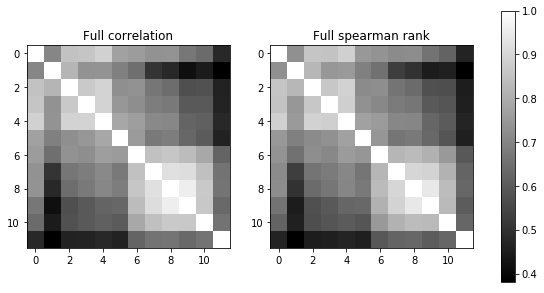

In [4]:
# Flatten and compute correlation matrix
flatData = np.array([data[:,:,i].flatten() for i in range(nChannels)])
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
im1 = ax[0].imshow(np.corrcoef(flatData), cmap="gray")
im2 = ax[1].imshow(spMat(flatData), cmap="gray")
ax[0].set_title("Full correlation")
ax[1].set_title("Full spearman rank")
fig.colorbar(im1, ax=ax, orientation='vertical')
plt.show()

For window of 1.0 consider 5 point correlation over 198 trials


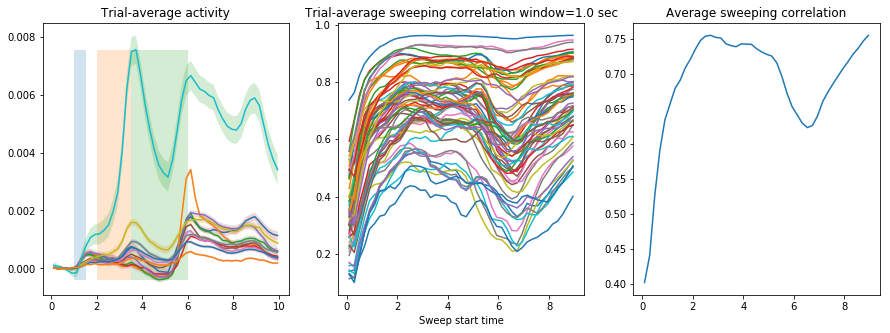

In [7]:
# Compute windowed correlation
windowsize_T = 1.0 # Seconds
windowsize = int(windowsize_T / params["timestep"])
print("For window of", windowsize_T, "consider", windowsize, "point correlation over", nTrials, "trials")
corrWindowed = np.zeros((nTimes-windowsize, nChannels, nChannels))
nOverlap = nTimes-windowsize

for j in range(nOverlap):
    flatData = np.array([data[:,j:j+windowsize,i].flatten() for i in range(nChannels)])
    corrWindowed[j] = np.corrcoef(flatData)


fig, ax = plt.subplots(ncols=3, figsize=(15,5))

# Plot mean and variance
ax[0].set_title("Trial-average activity")
act_lst = [np.mean(data[:,:,i], axis=0) for i in range(nChannels)]
err_lst = [np.std(data[:,:,i], axis=0, ddof=1) / np.sqrt(nTrials) for i in range(nChannels)]

# Fill in bars for the cue, lick and texture times
act_range = (np.min(act_lst), np.max(act_lst))
ax[0].fill_betweenx(act_range, params["range_CUE"][0], params["range_CUE"][1], alpha=0.2)
ax[0].fill_betweenx(act_range, params["range_TEX"][0], params["range_TEX"][1], alpha=0.2)
ax[0].fill_betweenx(act_range, params["range_LIK"][0], params["range_LIK"][1], alpha=0.2)

for act, err in zip(act_lst, err_lst):
    ax[0].plot(tlst, act)
    ax[0].fill_between(tlst, act-err, act+err, alpha=0.2)

# Plot sweeping correlation
ax[1].set_title("Trial-average sweeping correlation window="+str(windowsize_T)+" sec")
ax[1].set_xlabel("Sweep start time")
for i in range(nChannels):
    for j in range(i+1, nChannels):
        ax[1].plot(tlst[:nOverlap], corrWindowed[:, i, j], label="["+str(i)+","+str(j)+"]")

ax[2].set_title("Average sweeping correlation")
ax[2].plot(tlst[:nOverlap], np.mean(corrWindowed, axis=(1,2)))
    
plt.show()
    
# Interactive
# def f(i):
#     plt.figure()
#     plt.imshow(corrWindowed[i], cmap="gray")
#     plt.colorbar()
#     plt.show()
    
# interactive_plot = interactive(f, i=(0, nTimes-windowsize-1, 1))
# output = interactive_plot.children[-1]
# output.layout.height = '350px'
# interactive_plot